#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy import interpolate
import scipy

In [2]:
import sys
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 20

In [6]:
mi = [mp for i in range(node_N)]

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [16]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [17]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [18]:
E = 210e9

In [19]:
E*Ar/1e10

1.6991625880187402

In [20]:
diag_DT = 1.5*np.array([1, 1, 1])

In [21]:
DT=np.diag(diag_DT) # (35) in [2]

In [22]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [23]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [24]:
CT=np.diag(diag_CT)

In [25]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [26]:
# angles should be in radians, otherwise np.radians them
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]

    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [27]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [28]:
rng = np.random.default_rng()

In [29]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [30]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [31]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.65774964,  0.69328557,  0.29448348],
       [-0.57320571,  0.71434124, -0.40143718],
       [-0.4886723 ,  0.09524555,  0.86725294]])

In [32]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.001246


In [33]:
Ret.shape

(20, 3, 3)

In [34]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [35]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))
    return np.array(ans).T

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000132


In [37]:
C1(dx,dy,dz,Ret)

array([[ 1.98765483e-01,  1.04689392e-01,  1.18559049e+00,
        -5.48554384e-04, -7.50917117e-01, -2.13579445e-05,
         8.50895031e-01,  7.24570131e-01, -1.54174346e+00,
         4.50951359e-01, -3.08746929e-01, -2.32493124e-01,
        -2.08364628e+00,  1.18340504e+00, -1.36187265e+00,
         2.66840436e-02, -1.50517611e-01, -1.85526055e+00,
         1.73390700e+00,  1.13778333e+00],
       [-1.78965868e+00,  8.45874101e-01,  1.87804622e-01,
        -1.25688521e+00,  3.48834040e-02,  1.92190712e-01,
        -2.15250710e+00, -2.00042579e+00, -3.08117756e+00,
        -8.95824076e-01,  1.69742891e-02,  7.61867378e-01,
         1.92621779e+00,  9.06726450e-01,  6.24471912e-02,
        -1.24493641e-01,  2.03369002e+00,  6.99743177e-01,
        -2.76167699e+00, -8.69105892e-01],
       [ 9.60924122e-01, -2.39901198e-01,  1.22029970e-01,
         1.69820754e+00,  8.14126240e-01, -1.54870801e+00,
         1.41288467e+00, -1.52537929e+00,  2.59861755e+00,
        -5.36243305e-01, -2.7

In [38]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret).T

array([[ 1.14072186e+03, -1.02709119e+04,  5.51477615e+03],
       [ 6.00815976e+02,  4.85450017e+03, -1.37680112e+03],
       [ 6.80414407e+03,  1.07781710e+03,  7.00334139e+02],
       [-3.14817222e+00, -7.21330685e+03,  9.74607070e+03],
       [-4.30953882e+03,  2.00197039e+02,  4.67229812e+03],
       [-1.22573968e-01,  1.10298902e+03, -8.88808785e+03],
       [ 4.88331546e+03, -1.23533113e+04,  8.10859310e+03],
       [ 4.15833257e+03, -1.14805115e+04, -8.75420351e+03],
       [-8.84811806e+03, -1.76829826e+04,  1.49135543e+04],
       [ 2.58802515e+03, -5.14116478e+03, -3.07751853e+03],
       [-1.77190911e+03,  9.74160215e+01, -1.55990413e+02],
       [-1.33428593e+03,  4.37238274e+03,  7.05144625e+02],
       [-1.19581167e+04,  1.10546292e+04,  4.35107340e+03],
       [ 6.79160171e+03,  5.20373387e+03,  1.21636230e+04],
       [-7.81583338e+03,  3.58386550e+02,  2.06345736e+03],
       [ 1.53140632e+02, -7.14473230e+02, -8.75973620e+02],
       [-8.63825680e+02,  1.16714161e+04

In [40]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000118


In [41]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html
# 1-D Gray-Scott

In [42]:
I=np.identity(3)

In [43]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000351


In [44]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [45]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [46]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [47]:
DR=np.diag(diag_DR)

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [51]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [52]:
def Re_b(Ret):
    return Ret

In [53]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000030


In [54]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
#     B=np.sqrt(x**2+y**2+z**2)
    return np.linalg.solve(Ret.astype(np.float64), B.T.astype(np.float64)) # here new 
#     return B.T

#     print(Ret.shape)
#     print(B.shape)
#     return np.einsum('ijk,ik->ij',Ret.astype(np.float64), B.T.astype(np.float64))
#     return (Ret.astype(np.float64)@B.astype(np.float64)).T # here new 

In [55]:
phi(x,y,z,Ret,None,None)

array([[ 2.80728875, -0.05576276, -0.73571073],
       [ 0.56060818, -0.78083684, -1.91753252],
       [ 0.08053567,  1.0861884 ,  0.34243417],
       [-0.20495478, -0.79158813, -0.36115101],
       [-0.31737417,  0.41488865,  1.56316398],
       [-0.23464655, -1.4964816 , -0.64794963],
       [-0.11230524, -0.28819369,  0.98558629],
       [ 0.56793247,  0.43963244,  0.3100847 ],
       [-2.12610436,  1.10000402,  0.52209372],
       [ 1.07687625,  1.58687866, -0.62068949],
       [-1.47454474, -0.51833758, -0.03174475],
       [ 0.85831542,  0.03009507, -0.4326488 ],
       [-0.96405882, -1.49587429, -0.24638491],
       [ 0.33138091,  2.16857022, -0.88500788],
       [ 0.74858311, -1.10892137,  1.3582292 ],
       [ 1.23457929, -0.10826113,  0.41710007],
       [-1.30555638, -1.13519219,  0.46269545],
       [ 0.17215135, -0.65335116,  0.99263218],
       [-0.99574642, -0.45008398, -1.03017946],
       [-0.24331814, -0.70568084,  1.73676679]])

In [56]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000155


In [57]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [58]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)

    return np.apply_along_axis(Π_, 1, xyz)


In [59]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000432


In [60]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [61]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.000370


In [62]:
ωe(φ,θ,ψ,None,None,None)

array([[ 0.90575777,  0.45162993, -0.35761292],
       [ 0.19201552,  0.59880223, -0.71927094],
       [-0.91218799,  2.30518192, -0.72460009],
       [ 0.31456561,  0.71480385,  0.76365389],
       [ 0.71835935, -0.2721602 ,  0.20337584],
       [ 1.3357025 ,  0.165399  , -0.19183008],
       [-0.6192269 , -0.53798358, -0.86024387],
       [ 1.02477292,  1.35611339,  1.10338359],
       [-0.77958392, -0.77923848,  0.23750288],
       [ 0.93312284,  0.69010714,  1.11319116],
       [ 1.00484093, -0.69681339, -0.7217523 ],
       [-1.35885005,  1.90014806,  0.53086072],
       [ 1.17764223, -0.7948891 ,  0.52351683],
       [ 0.33673432, -0.50613059,  0.61023573],
       [-0.14946365,  1.73954384,  0.46170063],
       [ 0.05224432, -0.31838668, -0.14319161],
       [-0.9973969 , -0.12849152, -0.01338306],
       [ 0.63898932, -1.28842872,  0.96909544],
       [ 0.2358124 , -1.34921592,  0.90431467],
       [ 0.14726874, -1.11015138,  0.96023352]])

In [63]:
def d_s(f,a,b,c,Ret,omega): # here

    fun = f(a,b,c,Ret,omega, None)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)



    return np.einsum('ijk,ik->ij',K, fun).T

In [64]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [65]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[-0.00612357, -0.01027284, -0.00663843,  0.00383341,  0.01035801,
         0.00756023,  0.01145113, -0.00114324, -0.00514484, -0.01978911,
         0.00435314, -0.0041639 ,  0.01116954, -0.0273743 ,  0.02215068,
         0.00472349,  0.0143245 ,  0.01478255, -0.00524528,  0.02194933],
       [ 0.0987646 ,  0.19695165, -0.03355502,  0.03431497, -0.15930447,
         0.06275621, -0.09965685, -0.02595503, -0.07128641,  0.07176517,
        -0.01001905,  0.05098731,  0.01603387,  0.09155013, -0.12925178,
        -0.03070048, -0.05799743, -0.09781634,  0.0942038 , -0.17601839],
       [-0.03085182, -0.08320388,  0.10799653, -0.07738868,  0.04438497,
        -0.14767737, -0.02783567,  0.03889245,  0.12924283,  0.14914414,
        -0.03860938, -0.00471392, -0.14105065,  0.21407897, -0.11773542,
        -0.02194961, -0.10187431, -0.06694651, -0.03608755, -0.0684445 ]])

In [66]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.000651


In [67]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [68]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [69]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[ 1.68850104e-08, -9.80997435e-08, -1.32903028e-06,
         4.62559909e-07,  1.97770170e-07, -1.71263393e-07,
         1.21046738e-07,  3.65201916e-08,  1.29765575e-06,
        -9.18405745e-07, -2.66827927e-07, -2.67089186e-07,
        -1.81938651e-06, -1.32364070e-06,  7.18532644e-07,
         1.62200953e-06, -7.79664369e-07,  1.90370756e-06,
        -2.17056220e-06,  1.14074794e-06],
       [-1.18388158e-02,  1.56048353e-02,  6.51429068e-03,
         1.68541367e-03, -2.56374604e-03,  5.14933800e-03,
        -8.55693315e-03,  2.34276923e-03,  7.31527224e-03,
         9.40958945e-03, -5.19729409e-03,  8.62742933e-03,
         1.39436156e-02, -7.72500368e-03, -9.45610966e-03,
        -6.86855370e-03, -4.49702139e-03, -7.54629983e-03,
         1.11348510e-02,  1.67496588e-03],
       [ 1.16688515e-02, -1.46146695e-02,  6.91060553e-03,
        -6.35805738e-03,  5.66096576e-04, -3.41957831e-03,
         7.33461070e-03, -2.71179741e-03, -2.04239388e-02,
        -1.32772035e-04,  7.8

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T -fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
ne_(dx,dy,dz,DT,Ret)

array([[-1.14072186e+03, -6.00815976e+02, -6.80414407e+03,
         3.14817222e+00,  4.30953882e+03,  1.22573968e-01,
        -4.88331546e+03, -4.15833257e+03,  8.84811806e+03,
        -2.58802515e+03,  1.77190911e+03,  1.33428593e+03,
         1.19581167e+04, -6.79160171e+03,  7.81583338e+03,
        -1.53140632e+02,  8.63825680e+02,  1.06474032e+04,
        -9.95095112e+03, -6.52977715e+03],
       [ 1.02709119e+04, -4.85450017e+03, -1.07781710e+03,
         7.21330685e+03, -2.00197039e+02, -1.10298902e+03,
         1.23533113e+04,  1.14805115e+04,  1.76829826e+04,
         5.14116478e+03, -9.74160215e+01, -4.37238274e+03,
        -1.10546292e+04, -5.20373387e+03, -3.58386550e+02,
         7.14473230e+02, -1.16714161e+04, -4.01584984e+03,
         1.58493580e+04,  4.98782821e+03],
       [-5.64294069e+03,  1.24863658e+03, -8.28498681e+02,
        -9.87423524e+03, -4.80046266e+03,  8.75992330e+03,
        -8.23675764e+03,  8.62603896e+03, -1.50417188e+04,
         2.94935398e+03,  2.7

In [72]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.000686


In [73]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[ 7.86703400e+01, -1.40984485e+06,  6.15226261e+05],
       [ 5.88094505e+01, -3.61698821e+06,  3.02310665e+06],
       [ 1.00958012e+02, -8.47100302e+05, -1.72686178e+05],
       [ 6.34407633e+02, -3.15247586e+06, -3.25584595e+06],
       [-1.18433322e+02,  1.32814256e+06, -1.31853255e+05],
       [ 9.09041848e+01, -9.27299800e+05,  9.07632521e+03],
       [-4.36288769e+02,  3.20711703e+06,  1.19990030e+06],
       [-2.22131329e+00, -3.29352588e+04,  5.53755690e+04],
       [ 1.78961825e+02,  1.39468624e+06, -3.20254342e+06],
       [ 3.10790374e+00, -3.26402509e+04,  1.24735234e+03],
       [-1.69706700e+02,  7.40694771e+05,  9.73563361e+05],
       [ 1.43426990e+01, -1.44557337e+05, -3.18401528e+02],
       [-4.49901857e+01,  5.39989868e+05, -8.55479587e+04],
       [-4.91814821e+01,  3.14328581e+06, -2.64663736e+06],
       [-1.33966066e+02, -6.27155447e+05,  1.98044816e+06],
       [-4.19867627e+02,  2.79842520e+06,  1.44273434e+06],
       [-1.24797291e+02,  4.68595075e+05

In [74]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-6.81099109e+08,  6.14551973e+07,  1.40917060e+08],
       [-2.84565737e+08,  3.02282493e+08,  3.61670651e+08],
       [ 2.93975254e+08, -1.72395143e+07,  8.47391323e+07],
       [-1.28320194e+08, -3.25597299e+08,  3.15234883e+08],
       [-8.93481933e+08, -1.32737802e+07, -1.32902706e+08],
       [-1.52535879e+08,  8.92531466e+05,  9.27148797e+07],
       [-1.31845856e+08,  1.19976977e+08, -3.20724755e+08],
       [-8.84919439e+05,  5.53746930e+06,  3.29343828e+06],
       [-1.53030160e+08, -3.20269492e+08, -1.39483773e+08],
       [-4.25826265e+08,  8.25784267e+04,  3.22187042e+06],
       [-2.73512251e+07,  9.73536283e+07, -7.40721847e+07],
       [ 3.74835071e+07, -2.81292850e+04,  1.44594444e+07],
       [-3.30007680e+08, -8.58746663e+06, -5.40316559e+07],
       [-4.30155494e+08, -2.64706321e+08, -3.14371164e+08],
       [ 4.01539875e+06,  1.98045213e+08,  6.27159422e+07],
       [-8.27254135e+08,  1.44191536e+08, -2.79924414e+08],
       [-8.16562829e+08,  7.91215148e+07

In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000273


In [76]:
Re_b(Ret).shape

(20, 3, 3)

In [77]:
def Irho_e(Ret,Irho): # here
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [78]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [79]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [80]:
def d_me(φ,θ,ψ,Ret,omega):

    def f(a,b,c,Ret,omega, dummy2):
        return np.einsum('ijk,ik->ik', np.multiply(np.multiply(Ret,CR),Ret),omega.astype(np.float64)).squeeze()

    B=d_s(f,φ,θ,ψ,Ret.astype(np.float64),omega.astype(np.float64))

    return B.T.astype(np.float64)

In [81]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.000892


In [82]:
d_me_

array([[ 3.03522566e-03,  4.42341085e+02, -4.73023895e+02],
       [ 2.37019634e-02, -3.16282167e+02,  7.68723315e+01],
       [-3.32828108e-03,  3.25686661e+02, -2.92082467e+02],
       [ 2.20439952e-02, -4.19220091e+02,  1.96563471e+02],
       [-3.58318896e-03,  4.21210711e+02, -3.85036400e+02],
       [ 2.32489938e-02,  4.65970555e+01, -2.81449599e+02],
       [ 5.20256771e-02, -4.34105862e+02, -9.14105714e+01],
       [-6.23416525e-03,  5.85142003e+00,  5.71228301e+01],
       [-1.53655399e-02, -1.29213791e+01,  1.68137347e+02],
       [ 4.21062961e-04,  5.55488450e+02, -5.59769975e+02],
       [ 3.20246605e-02, -3.36237095e+02,  1.27563770e+01],
       [ 1.49458047e-03,  9.55524284e+01, -1.10654805e+02],
       [ 1.20744272e-03,  3.98871009e+02, -4.11088229e+02],
       [ 1.83579564e-02, -1.73737201e+02, -1.16972642e+01],
       [-6.94171964e-02, -4.11227011e+01,  7.42344002e+02],
       [-7.38773766e-03, -2.01231242e+01,  9.47515257e+01],
       [ 6.62537219e-03,  5.55188286e+02

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[-1.14072186e+03, -6.00815976e+02, -6.80414407e+03,
         3.14817222e+00,  4.30953882e+03,  1.22573968e-01,
        -4.88331546e+03, -4.15833257e+03,  8.84811806e+03,
        -2.58802515e+03,  1.77190911e+03,  1.33428593e+03,
         1.19581167e+04, -6.79160171e+03,  7.81583338e+03,
        -1.53140632e+02,  8.63825680e+02,  1.06474032e+04,
        -9.95095112e+03, -6.52977715e+03],
       [ 1.02709119e+04, -4.85450017e+03, -1.07781710e+03,
         7.21330685e+03, -2.00197039e+02, -1.10298902e+03,
         1.23533113e+04,  1.14805115e+04,  1.76829826e+04,
         5.14116478e+03, -9.74160215e+01, -4.37238274e+03,
        -1.10546292e+04, -5.20373387e+03, -3.58386550e+02,
         7.14473230e+02, -1.16714161e+04, -4.01584984e+03,
         1.58493580e+04,  4.98782821e+03],
       [-5.64294069e+03,  1.24863658e+03, -8.28498681e+02,
        -9.87423524e+03, -4.80046266e+03,  8.75992330e+03,
        -8.23675764e+03,  8.62603896e+03, -1.50417188e+04,
         2.94935398e+03,  2.7

### Static solution

In [84]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [85]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [86]:
Fx_0=82945396

In [87]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=30

In [88]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [89]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76])

In [90]:
delta_x=horizontal_length/(node_N-1)

In [91]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [92]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [93]:
M_totl

array([3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617, 3150635.90893617])

In [94]:
x0=x0-x0[-1]
z0=z0-z0[-1]

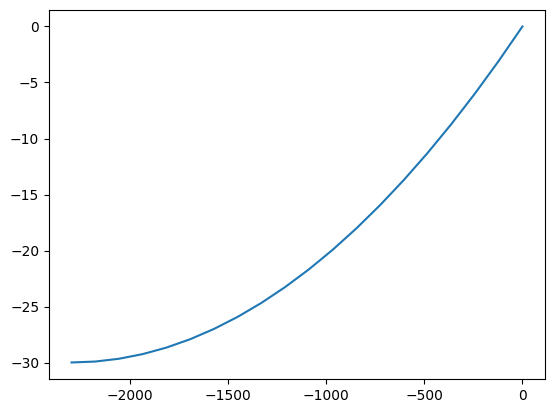

In [95]:
plt.plot(x0, z0)
plt.show()

In [96]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [97]:
init=1
for j in range(1,12):
    if j==1:
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:
        q0[(j-1)*node_N:j*node_N]=z0

In [98]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [99]:
V_rho=np.zeros(Irho_.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [100]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0*9.81,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

In [101]:
def static_func(Q): # It is not working properly for non zero roll, pitch and yaw; serves our needs though
    t=0

    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)


    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]

    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force=np.array([-Fx_0,0,0,0,0,0])

    Z0= - np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T


    Z =  Z1 + Z2 + Z0


############################################################

    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################



    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1))

    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))

    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=scipy.linalg.lstsq(A[i],B[i], check_finite=True)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)

    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)


    return ans

In [102]:
q0

array([-2298.34563041, -2177.38007092, -2056.41451142, -1935.44895193,
       -1814.48339243, -1693.51783294, -1572.55227344, -1451.58671394,
       -1330.62115445, -1209.65559495, -1088.69003546,  -967.72447596,
        -846.75891647,  -725.79335697,  -604.82779748,  -483.86223798,
        -362.89667849,  -241.93111899,  -120.9655595 ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
      

In [103]:
root_ = root(static_func, q0)

In [104]:
root_

 message: The iteration is not making good progress, as measured by the 
            improvement from the last ten iterations.
 success: False
  status: 5
     fun: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
       x: [-2.298e+03 -2.177e+03 ...  0.000e+00  0.000e+00]
  method: hybr
    nfev: 491
    fjac: [[ 0.000e+00  0.000e+00 ...  4.793e-16 -6.854e-44]
           [ 0.000e+00  0.000e+00 ...  8.402e-17 -1.201e-44]
           ...
           [ 0.000e+00  0.000e+00 ...  8.910e-19 -1.000e+00]
           [ 0.000e+00  0.000e+00 ...  6.207e-07  2.006e-25]]
       r: [-1.213e+01 -1.211e+01 ...  0.000e+00  0.000e+00]
     qtf: [-5.101e-01  3.480e-02 ...  0.000e+00  0.000e+00]

In [105]:
x0_,z0_=root_.x[:node_N],root_.x[4*node_N:5*node_N]

In [106]:
q0=root_.x

In [107]:
q0

array([-2298.34563041, -2177.38007092, -2056.41451142, -1935.44895193,
       -1814.48339243, -1693.51783294, -1572.55227344, -1451.58671394,
       -1330.62115445, -1209.65559495, -1088.69003546,  -967.72447596,
        -846.75891647,  -725.79335697,  -604.82779748,  -483.86223798,
        -362.89667849,  -241.93111899,  -120.9655595 ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
      

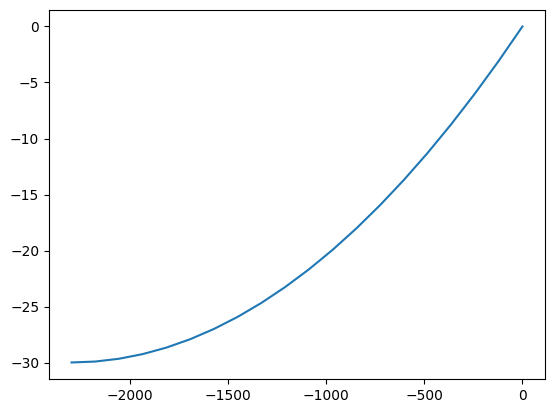

In [108]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [109]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [110]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [111]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [112]:
def FEA_u(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):


    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))

    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
        
        
#     print(vessel_movement)
    glob_force=np.dot(K, np.array(vessel_movement))
    
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    
#     return glob_force
#     print(glob_force)
#     print(np.linalg.inv(K)@glob_force)

    F=np.zeros(len(coord)*6)
    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]

    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [113]:
# 10 The Space Frame Element - verification
d,f=FEA_u(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6,24)),
        bc_val=[0]*18,
        vessel_movement=[ -0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                       ],
        coefs=[1,1,1,1,1,1])

In [114]:
-0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4

(-7.05e-06, -7e-08, 1.418e-05, 1.45e-06, 1.75e-06, 1.14e-06)

In [115]:
d

array([-7.050e-06, -7.000e-08,  1.418e-05,  1.450e-06,  1.750e-06,
        1.140e-06,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00])

In [116]:
f

array([-9.99786375e+00, -3.59333333e-03,  2.00042617e+01,  5.25000000e-05,
        1.75000000e-05,  3.18500000e-04,  9.87000000e+00, -3.06133333e-02,
       -1.07846667e-01, -2.03000000e-03, -1.74020000e-01,  2.99600000e-02,
        9.03000000e-02, -3.92933333e-02, -1.98520000e+01,  3.86400000e-02,
        1.23200000e-01, -1.59600000e-03,  3.75637500e-02,  7.35000000e-02,
       -4.44150000e-02, -9.64425000e-02, -1.83750000e-03, -8.70975000e-02])

In [117]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=210e6, G=84e6,  
              A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2,
#               A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5
             ):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])

    bc_node=list(range(6))
    bc_val=[0]*6

    vessel_move=np.zeros(len(X)*6)
    vessel_move[-6:]=vessel_movement

    d,f=FEA_u(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    return np.array(fors), np.array(mom), np.array(angle)

In [118]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

In [119]:
fors

array([[-1.51083061e+03,  1.27142464e+01, -1.69792201e+01],
       [-2.11002771e-10,  7.31588443e-08,  1.27549811e-08],
       [ 6.57746568e-08, -1.29501132e-07, -5.95218808e-08],
       [-8.06612661e-08, -6.17327807e-08, -9.50001322e-08],
       [ 2.41561793e-07,  2.63535185e-08,  1.22949132e-07],
       [-3.35276127e-08, -4.61077434e-08, -6.34536264e-08],
       [-6.61239028e-08,  1.13435817e-07, -6.65313564e-08],
       [-9.77888703e-09,  1.71842666e-07,  4.75847628e-09],
       [-7.63684511e-08,  3.06317816e-08, -6.23113010e-08],
       [-6.33299351e-08, -1.26048690e-07,  2.04890966e-08],
       [-2.23517418e-08,  5.24014467e-08, -2.87545845e-08],
       [ 2.04890966e-08,  3.18041433e-08,  9.45874490e-09],
       [-2.98023224e-08,  2.43016984e-08,  5.23868948e-09],
       [ 1.49011612e-08, -2.15368345e-09,  1.39698386e-09],
       [ 1.49011612e-07,  2.88127922e-09,  6.51925802e-09],
       [-3.20292792e-07,  8.70106452e-10, -7.12607570e-09],
       [ 3.04509837e-07,  3.73359577e-09

In [120]:
d

array([-7.050e-06, -7.000e-08,  1.418e-05,  1.450e-06,  1.750e-06,
        1.140e-06,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00])

### Vessle Simulation

In [121]:
sampleTime = 0.001              # sample time [seconds]
N = 100000                      # number of samples

In [122]:
N*sampleTime

100.0

In [123]:
vehicle=semisub('DPcontrol',2,-1,40.0,0,0)

In [124]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [125]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

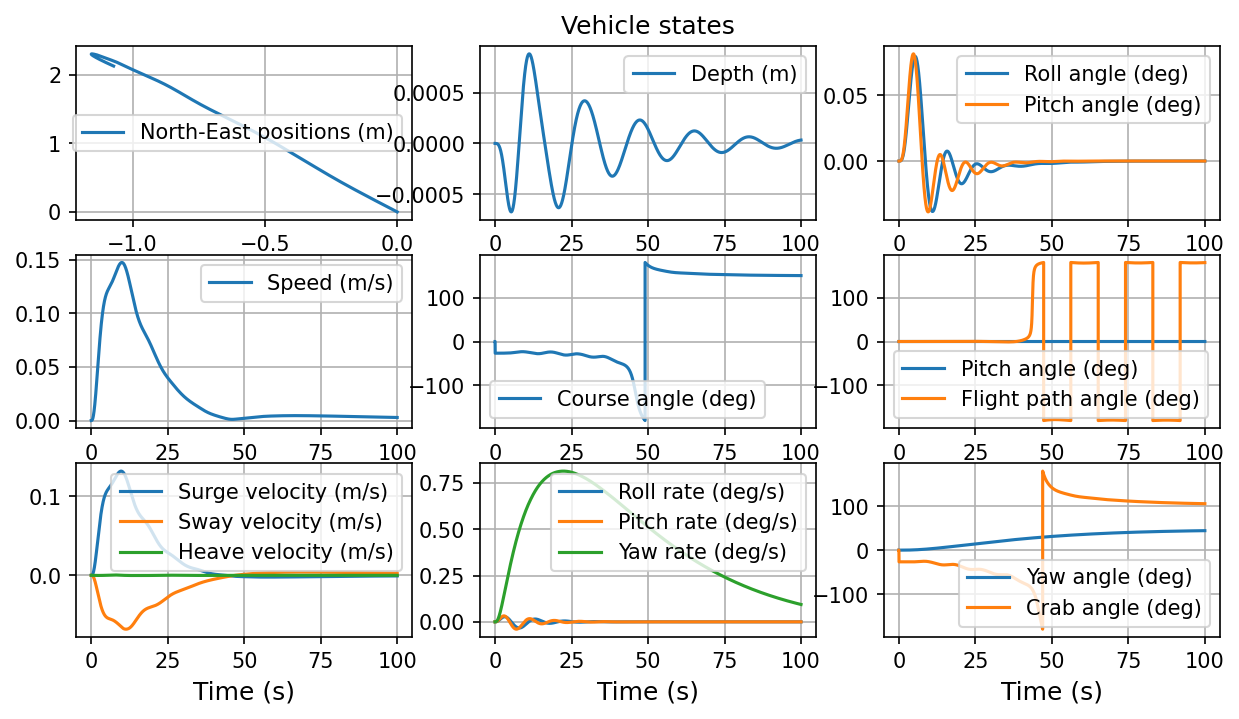

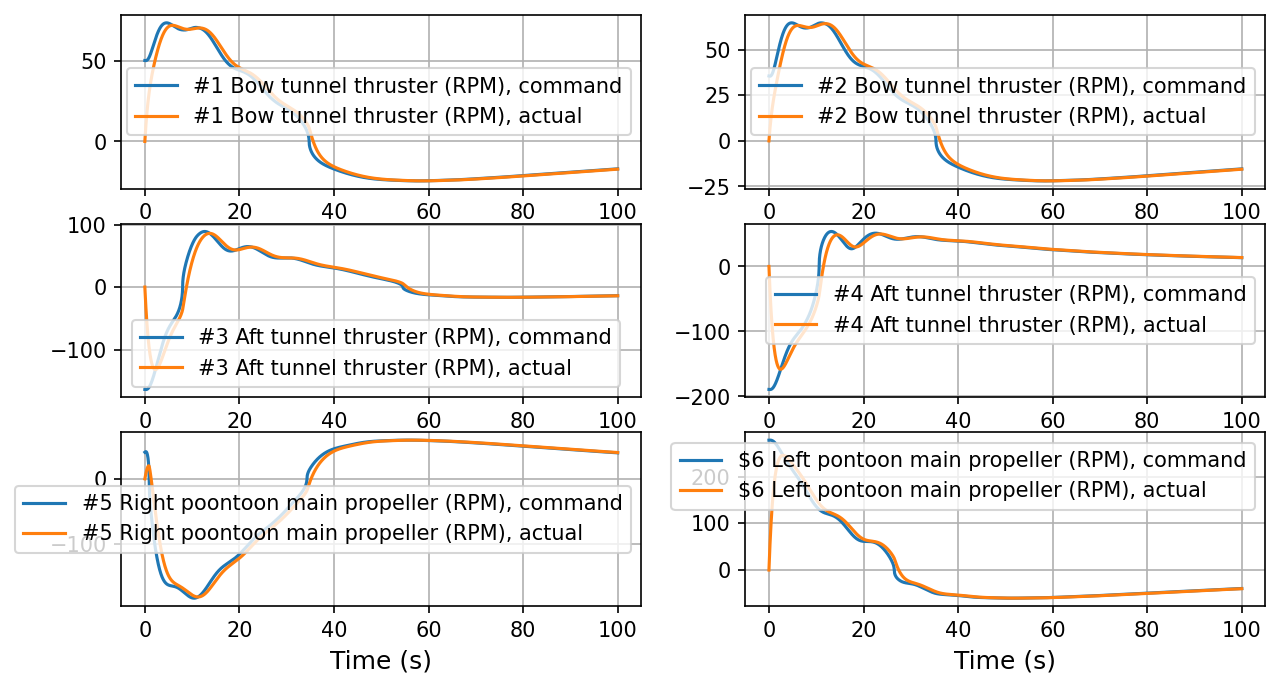

In [126]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [127]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

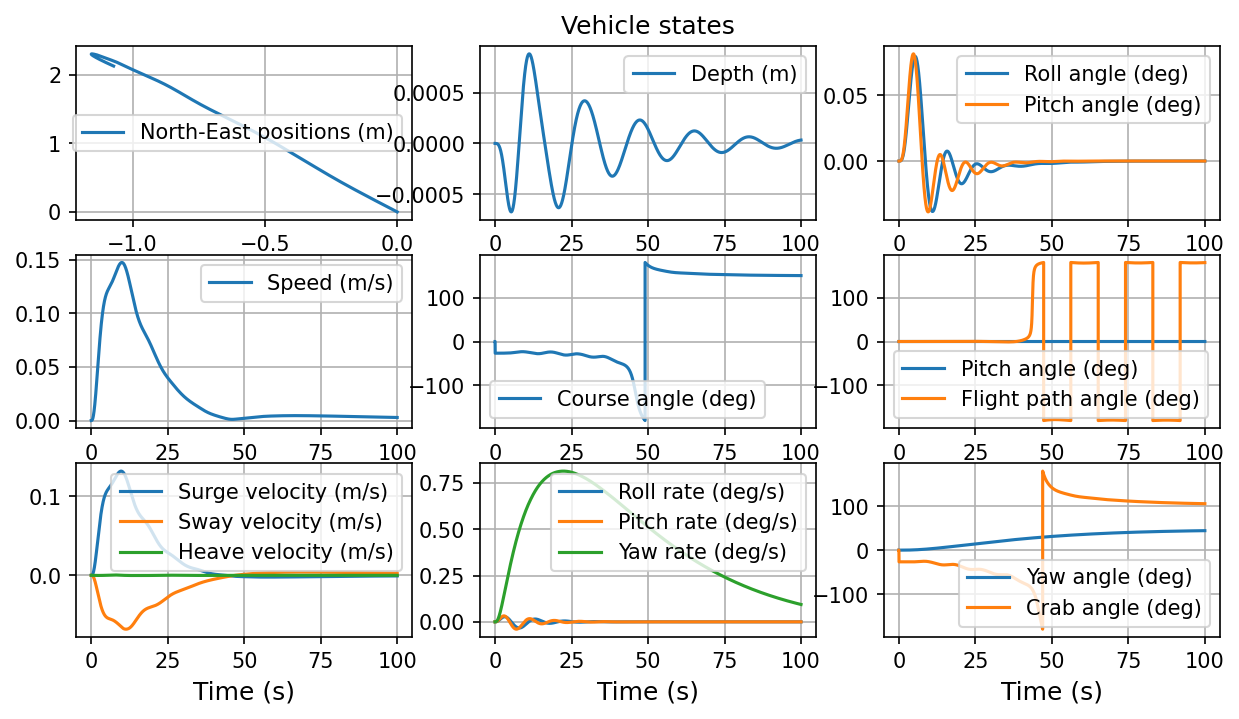

In [128]:
plotVehicleStates(simTime, simData, 3)

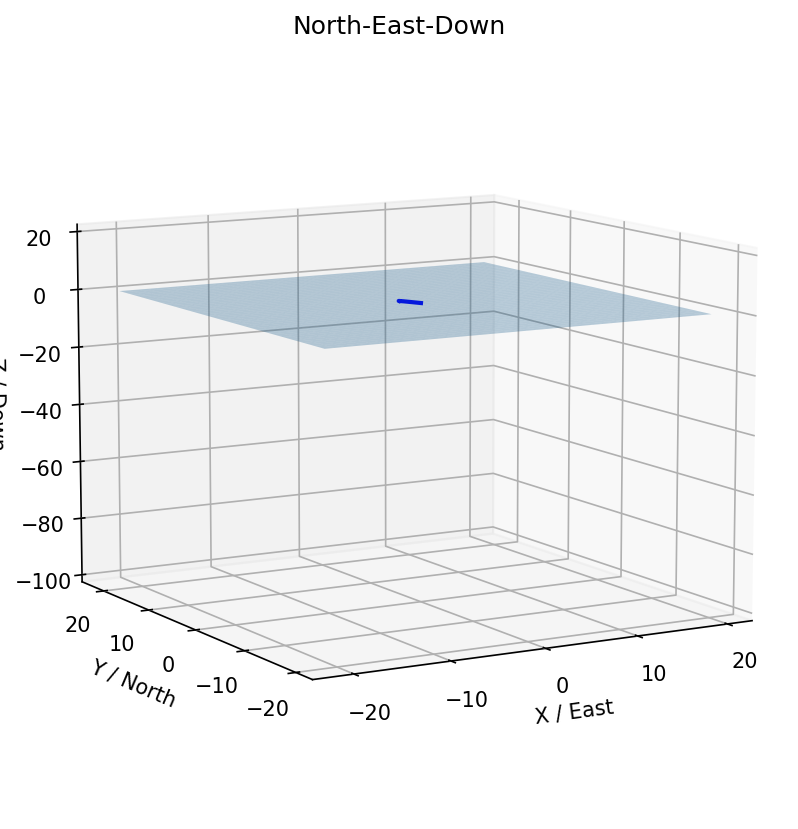

In [129]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [130]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [131]:
idx=1/0.01

In [132]:
idx

100.0

In [133]:
ssa(simData[:, 3][int(idx)])

4.347863402642815e-09

In [134]:
ssa(simData[:, 4][int(idx)])

5.966248384225992e-09

In [135]:
ssa(simData[:, 5][int(idx)])

1.3685324873335958e-08

In [136]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [137]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

### Dynamics

In [138]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(250)]
        self.wall_clock = datetime.now()

In [170]:
def grayscott1d(t, Q, coefs, T):

    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]

    idx = find_nearest(np.array(ans_t),  t)

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])




    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]


    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]


    vessel_movement = np.zeros(6).astype(np.float64)
    
    del_t = abs(t-T.my_t)
    
    vessel_movement[0] = u_ve*del_t
    vessel_movement[1] = v_ve*del_t 
    vessel_movement[2] = -w_ve*del_t 
    vessel_movement[3] = p_ve*del_t 
    vessel_movement[4] = q_ve*del_t 
    vessel_movement[5] = r_ve*del_t
    
    fors, mom, angle = PipeForce(x, y, z, vessel_movement, coefs)

#     φ,θ,ψ=angle.T 
    Ret = Re_t(φ,θ,ψ)

    Z0= - np.einsum('ijk,ik->ij', Re_b(Ret), fors).squeeze()

    Z1=d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T


    Z= (
        Z1
        + Z2
        +Z0
       )

############################################################
    RRRR=Re_b(Ret)


    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T

    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################


    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64),
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))

    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))

    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))

    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

    C0=-np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)), mom ).squeeze()
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################
    T.my_t=t

    if t>T.progression[0]:
        T.progression.pop(0)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()

    return np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

In [171]:
tspan = (0., 100)
T_ = MyTime()

In [172]:
coefs = [1, 1, 1, 1, 1, 1]

In [173]:
startTime1 = datetime.now()
us=solve_ivp(grayscott1d,
             tspan,
             q0,
             args=(coefs,T_,))
print(datetime.now() - startTime1)

Physical time:  0.002115760202290644  Iteration wall clock time:  0:00:01.724943
Physical time:  1.122086641725621  Iteration wall clock time:  0:00:04.829718
Physical time:  2.2909936099327446  Iteration wall clock time:  0:00:05.499408
Physical time:  3.0232978079163093  Iteration wall clock time:  0:00:05.771488
Physical time:  4.052640161132031  Iteration wall clock time:  0:00:04.205251
Physical time:  5.040692242169977  Iteration wall clock time:  0:00:03.764596
Physical time:  6.060327558544362  Iteration wall clock time:  0:00:03.976800
Physical time:  7.035569809209534  Iteration wall clock time:  0:00:03.334095
Physical time:  8.083878003427953  Iteration wall clock time:  0:00:03.306799
Physical time:  9.013821613177491  Iteration wall clock time:  0:00:03.389809
Physical time:  10.058973955273556  Iteration wall clock time:  0:00:02.719514
Physical time:  11.05577459032687  Iteration wall clock time:  0:00:03.248455
Physical time:  12.200245494374952  Iteration wall clock t

### Results

In [174]:
fin=us

In [175]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  8.753e-02 ...  9.936e+01  1.000e+02]
        y: [[-2.298e+03 -2.298e+03 ... -2.296e+03 -2.296e+03]
            [-2.177e+03 -2.177e+03 ... -2.177e+03 -2.177e+03]
            ...
            [ 0.000e+00  4.223e-05 ... -2.302e-05 -2.803e-05]
            [ 0.000e+00 -5.176e-12 ... -1.551e-04 -1.566e-04]]
      sol: None
 t_events: None
 y_events: None
     nfev: 350
     njev: 0
      nlu: 0

In [176]:
t=fin.t

In [177]:
fin=fin.y.T

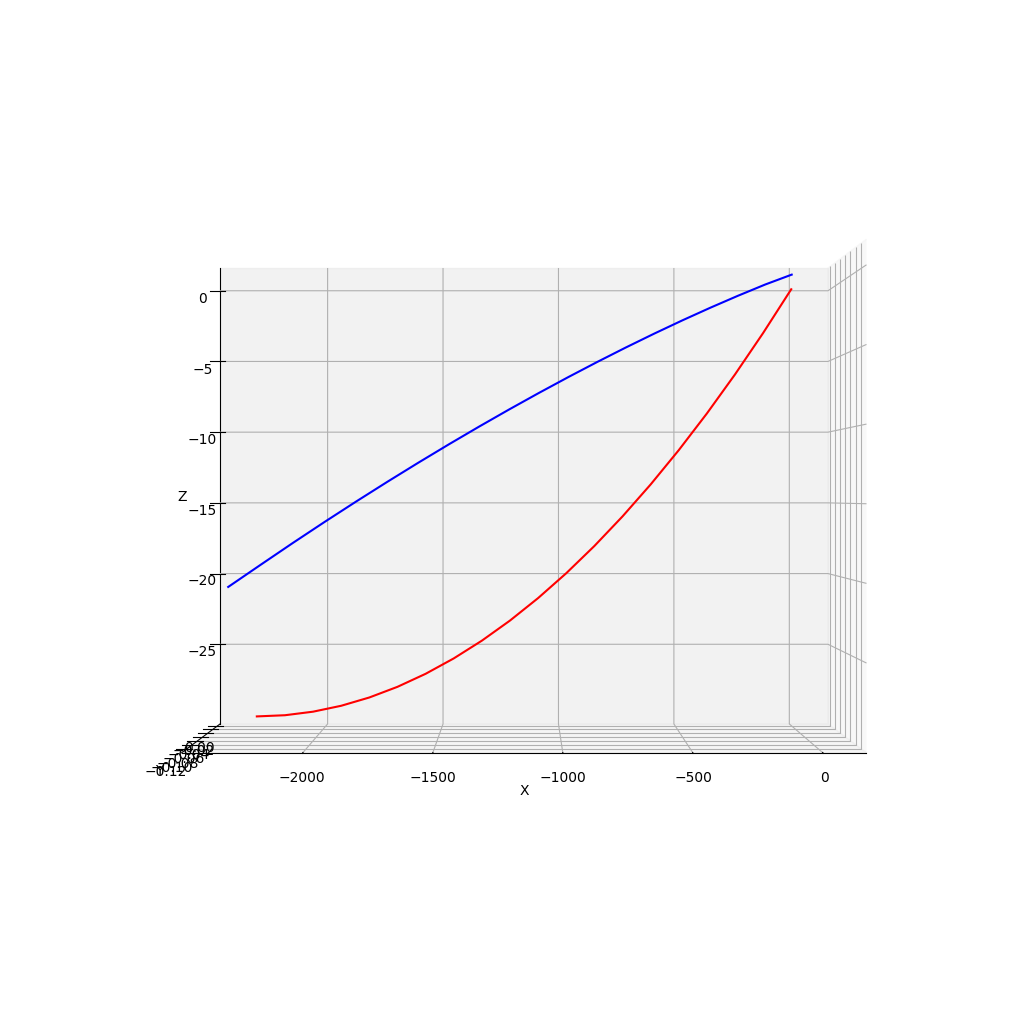

In [178]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
# ax.view_init(-45,-45)
# ax.view_init(-30,-30)
ax.view_init(0,-90)
plt.show()

In [179]:
X,Y,Z

(array([-2295.71518927, -2177.38117604, -2056.41573078, -1935.45026572,
        -1814.48478084, -1693.51927613, -1572.55375157, -1451.58820713,
        -1330.6226428 , -1209.65705858, -1088.69145445,  -967.72583039,
         -846.76018642,  -725.7945225 ,  -604.82883866,  -483.86313487,
         -362.89741115,  -241.9316675 ,  -120.96590392,    -2.6464065 ]),
 array([-0.1282076 , -0.12169368, -0.11493775, -0.10820051, -0.1014839 ,
        -0.09479019, -0.08812182, -0.08148134, -0.07487141, -0.06829475,
        -0.06175415, -0.05525247, -0.04879261, -0.04237755, -0.03601033,
        -0.02969407, -0.02343194, -0.01722721, -0.01108326, -0.00526869]),
 array([-20.26834709, -18.9089311 , -17.5305178 , -16.18407026,
        -14.86905711, -13.58508604, -12.33190363, -11.10939525,
         -9.91758514,  -8.75663676,  -7.62685354,  -6.52867999,
         -5.46270319,  -4.42965475,  -3.43041314,  -2.46600658,
         -1.53761626,  -0.64658021,   0.20560238,   0.9647958 ]))

In [180]:
X0,Y0,Z0

(array([-2298.34563041, -2177.38007092, -2056.41451142, -1935.44895193,
        -1814.48339243, -1693.51783294, -1572.55227344, -1451.58671394,
        -1330.62115445, -1209.65559495, -1088.69003546,  -967.72447596,
         -846.75891647,  -725.79335697,  -604.82779748,  -483.86223798,
         -362.89667849,  -241.93111899,  -120.9655595 ,     0.        ]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([-29.98978026, -29.90671078, -29.65750218, -29.24215398,
        -28.66066541, -27.91303536, -26.99926244, -25.91934491,
        -24.67328073, -23.26106756, -21.68270273, -19.93818327,
        -18.02750588, -15.95066696, -13.7076626 , -11.29848856,
         -8.72314029,  -5.98161294,  -3.07390134,   0.        ]))

In [181]:
us=fin.T

In [182]:
us.shape

(240, 56)

In [183]:
12*50

600

In [184]:
us.T[:,4*node_N+49]

array([ 0.00000000e+00, -3.11983755e-11, -2.51252182e-08, -1.57947680e-07,
       -3.59637863e-07, -6.07996879e-07, -8.78392551e-07, -1.16162594e-06,
       -1.45584546e-06, -1.76195539e-06, -2.08170739e-06, -2.41694671e-06,
       -2.76929316e-06, -3.14000055e-06, -3.52995553e-06, -3.93983434e-06,
       -4.37042228e-06, -4.82304397e-06, -5.29998862e-06, -5.80489091e-06,
       -6.34303314e-06, -6.92156505e-06, -7.54956391e-06, -8.23770892e-06,
       -8.99697390e-06, -9.83618817e-06, -1.07595415e-05, -1.17676053e-05,
       -1.28635934e-05, -1.40602389e-05, -1.53792626e-05, -1.68347432e-05,
       -1.84119319e-05, -2.01022101e-05, -2.19420095e-05, -2.39251376e-05,
       -2.56062992e-05, -2.72438094e-05, -2.89425962e-05, -3.07429029e-05,
       -3.25645525e-05, -3.42591392e-05, -3.57525869e-05, -3.70684116e-05,
       -3.82419164e-05, -3.92718747e-05, -4.01543732e-05, -4.09270124e-05,
       -4.16587468e-05, -4.24118472e-05, -4.31982928e-05, -4.39565346e-05,
       -4.46078181e-05, -

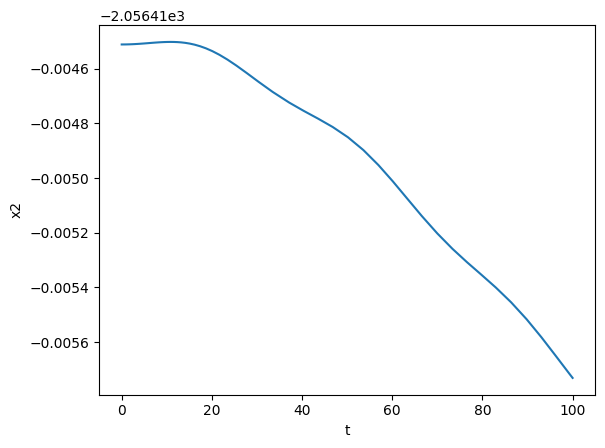

In [185]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

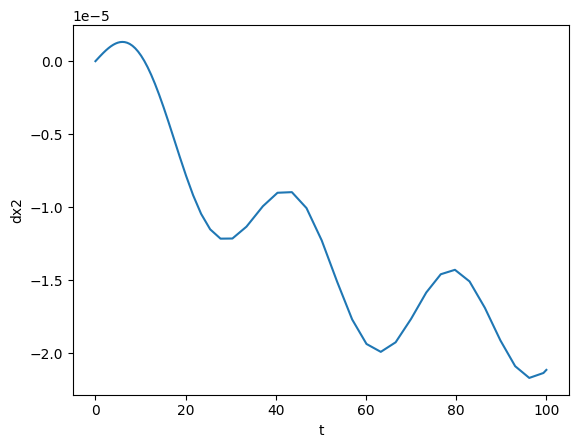

In [186]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

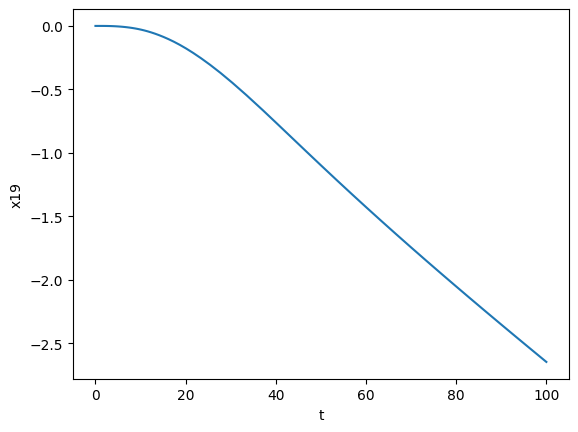

In [187]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x19')
plt.show()

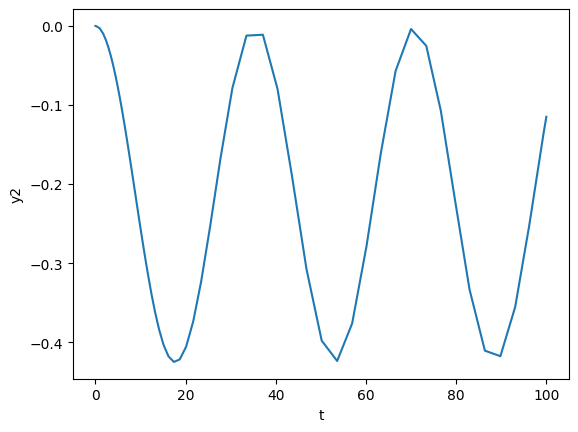

In [188]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

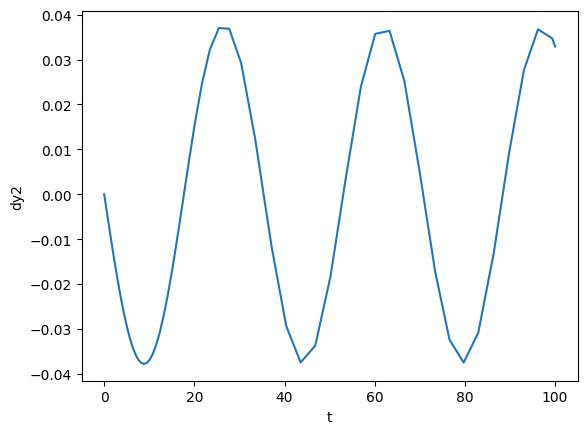

In [189]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

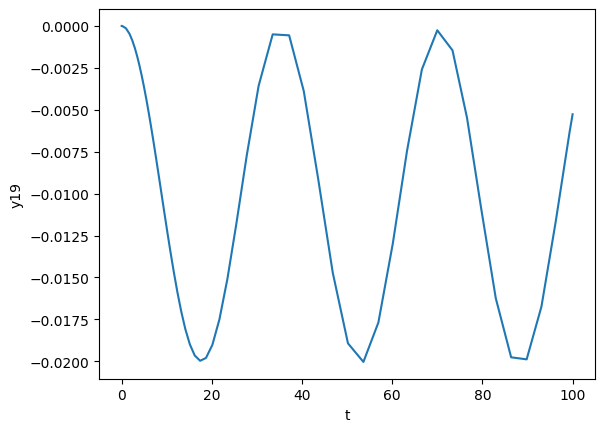

In [190]:
plt.plot(t,us.T[:,2*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('y19')
plt.show()

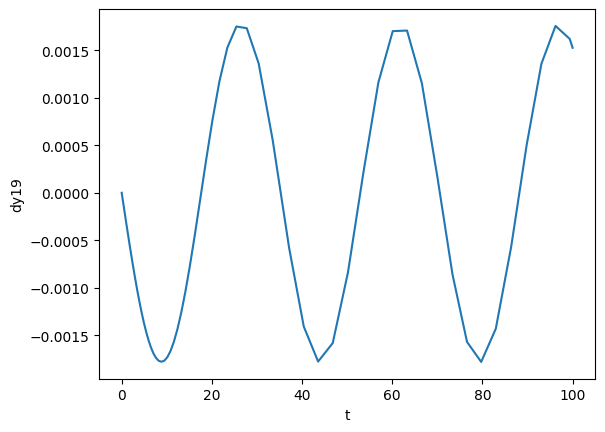

In [191]:
plt.plot(t,us.T[:,3*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('dy19')
plt.show()

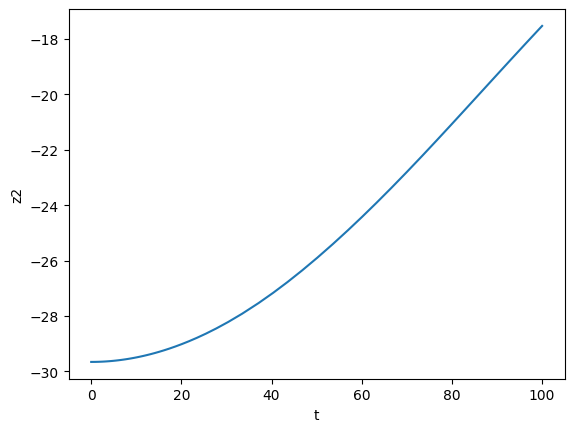

In [192]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

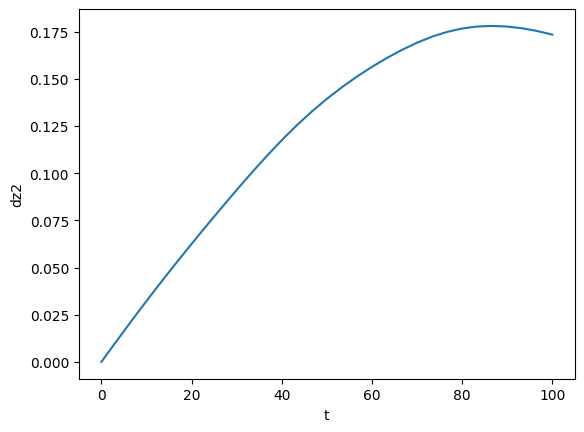

In [193]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

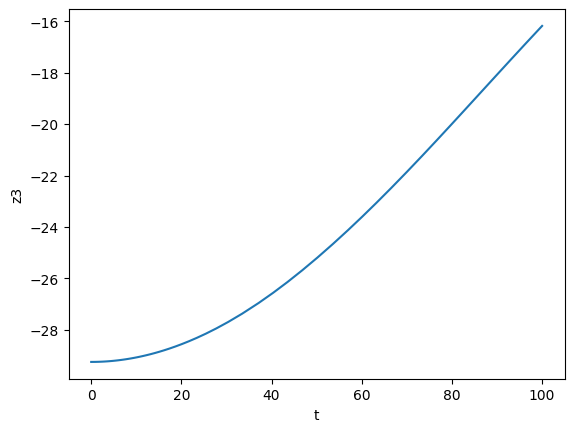

In [194]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

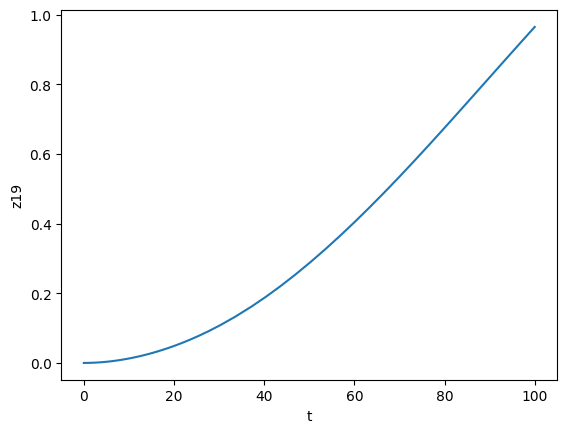

In [195]:
plt.plot(t,us.T[:,4*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('z19')
plt.show()

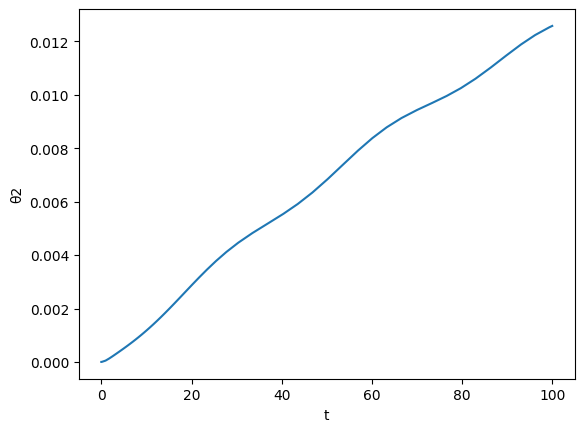

In [196]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

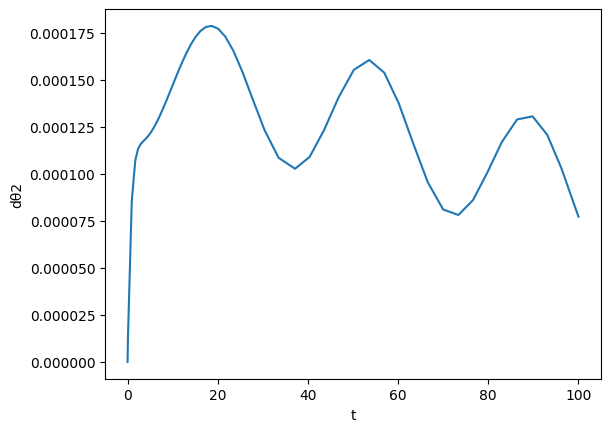

In [197]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

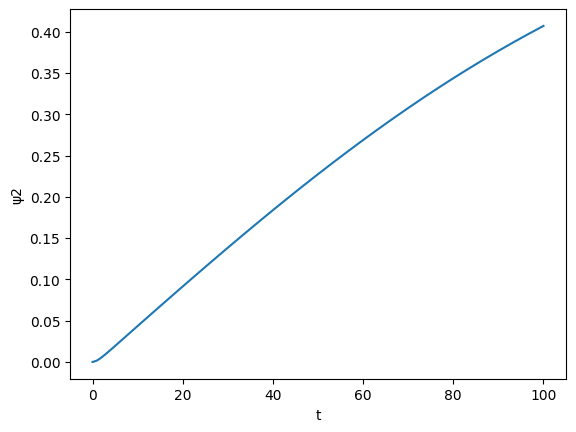

In [198]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

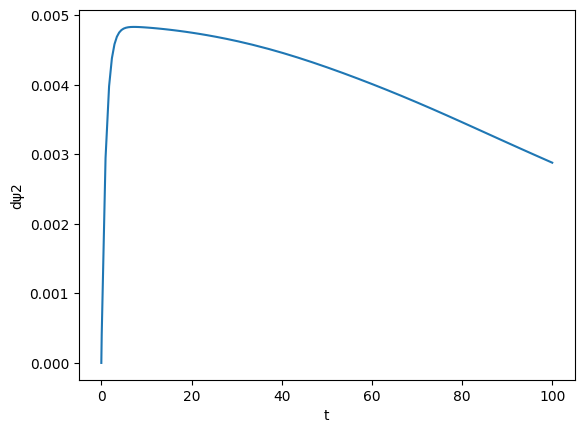

In [199]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

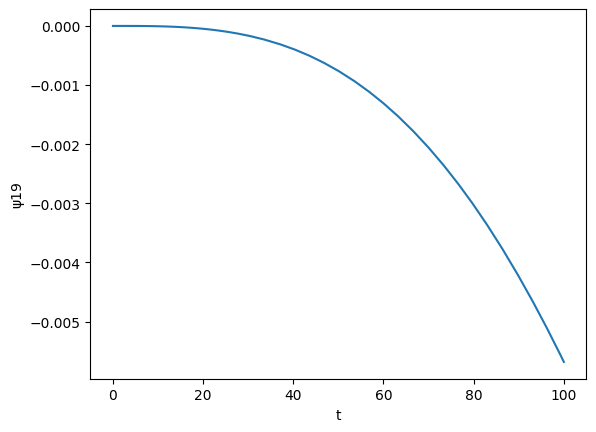

In [200]:
plt.plot(t,us.T[:,10*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('ψ19')
plt.show()